<a href="https://colab.research.google.com/github/merongedrago/Explainable_Deep_Learning/blob/main/explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Explainable Deep Learning by Meron Gedrago


## Part 1: setting up enviroment

In [6]:
# uncomment the following to install packages
# !pip install kagglehub
# !pip install torch
!pip install pytorch-gradcam
!pip install grad-cam

# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import torch
from torchvision.models import resnet50, ResNet50_Weights
import os
import os, random
random.seed(42)
from glob import glob
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
# download dataset from kaggle
path = kagglehub.dataset_download("mdwaquarazam/agricultural-crops-image-classification")
agri_data = path +"/Agricultural-crops/"


Using Colab cache for faster access to the 'agricultural-crops-image-classification' dataset.


In [7]:
# look at the first few labels of the datset
Crops_label = sorted(os.listdir(agri_data))
Crops_label

['Cherry',
 'Coffee-plant',
 'Cucumber',
 'Fox_nut(Makhana)',
 'Lemon',
 'Olive-tree',
 'Pearl_millet(bajra)',
 'Tobacco-plant',
 'almond',
 'banana',
 'cardamom',
 'chilli',
 'clove',
 'coconut',
 'cotton',
 'gram',
 'jowar',
 'jute',
 'maize',
 'mustard-oil',
 'papaya',
 'pineapple',
 'rice',
 'soyabean',
 'sugarcane',
 'sunflower',
 'tea',
 'tomato',
 'vigna-radiati(Mung)',
 'wheat']

## Part 2: GradCAM

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


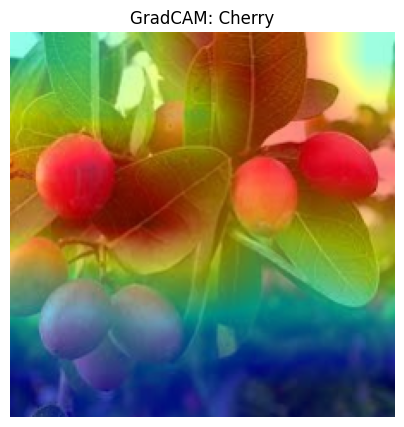

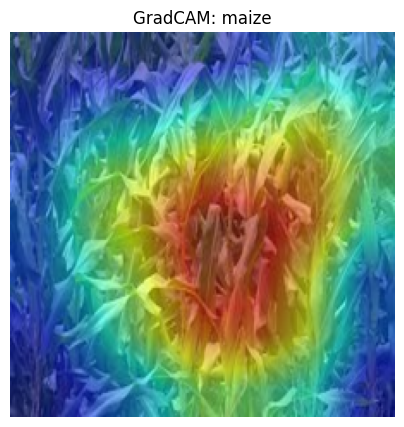

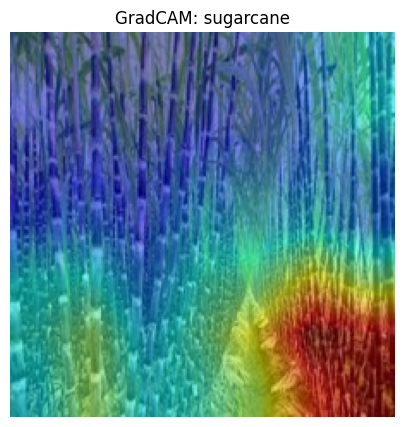

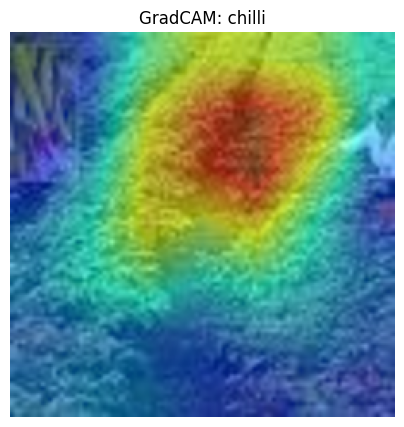

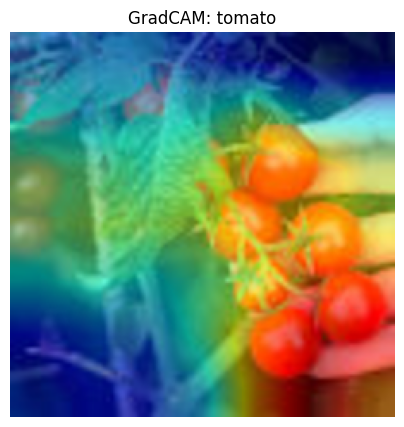

Execution time GradCAM: 16.881499528884888 seconds


In [8]:
import time
start_time = time.time()
# get image path for pictures
image_paths = glob(os.path.join(agri_data, "*", "*.jpg"))

# choose four different crops to visualize
selected_classes = [
    "Cherry",
    "maize",
    "sugarcane",
    "chilli",
    "tomato"
]

sample_image_paths = []

for cls in selected_classes:
    cls_path = os.path.join(agri_data, cls)
    all_imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith((".jpg", ".png", ".jpeg"))]
    if all_imgs:
        sample_image_paths.append(random.choice(all_imgs))

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load model and GradCAM - source: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Loop through the few selected images
for i,img_path in enumerate(sample_image_paths):
    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    input_tensor = transform(img).unsqueeze(0)

    # get prediction for each
    with torch.no_grad():
        output = model(input_tensor)
        class_idx = torch.argmax(output).item()

    # computer gradCAM
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"GradCAM: {selected_classes[i]}")
    plt.axis("off")
    plt.show()

end_time = time.time()
print(f"Execution time GradCAM: {end_time - start_time} seconds")

*The above code snippet was generated using ChatGPT 5o on 10/05/25 at 3:30 pm, specifically to preprocess the image for the five classes*

## Part 3: AblationCAM

100%|██████████| 64/64 [09:03<00:00,  8.50s/it]


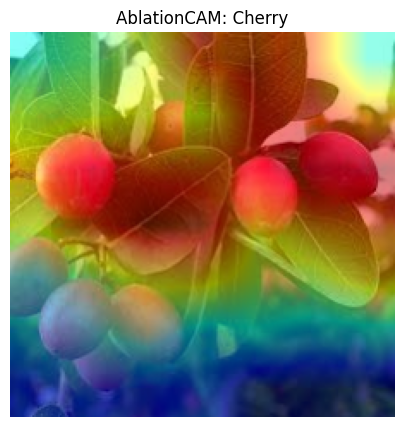

100%|██████████| 64/64 [08:48<00:00,  8.26s/it]


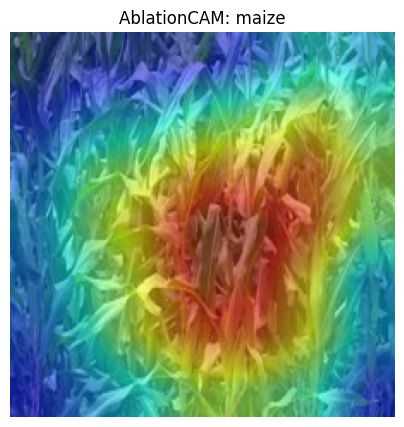

100%|██████████| 64/64 [08:50<00:00,  8.28s/it]


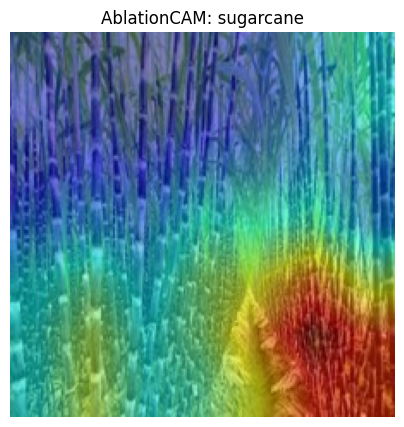

100%|██████████| 64/64 [08:50<00:00,  8.29s/it]


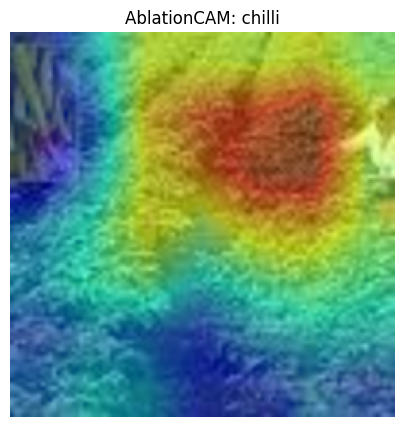

100%|██████████| 64/64 [08:59<00:00,  8.42s/it]


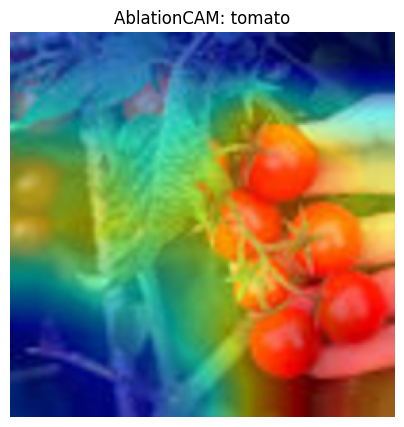

Execution time AblationCAM: 2677.314290523529 seconds


In [9]:
# try AblationCAM
start_time = time.time()
cam = AblationCAM(model=model, target_layers=target_layers)

# replicate same thing for AblationCAM
for i,img_path in enumerate(sample_image_paths):
    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    input_tensor = transform(img).unsqueeze(0)
    # prediction
    with torch.no_grad():
        output = model(input_tensor)
        class_idx = torch.argmax(output).item()
    # get result
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"AblationCAM: {selected_classes[i]}")
    plt.axis("off")
    plt.show()

end_time = time.time()
print(f"Execution time AblationCAM: {end_time - start_time} seconds")

## Part 4: ScoreCAM

100%|██████████| 128/128 [08:26<00:00,  3.96s/it]


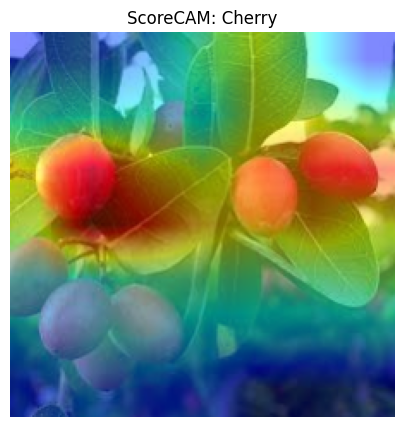

100%|██████████| 128/128 [06:51<00:00,  3.21s/it]


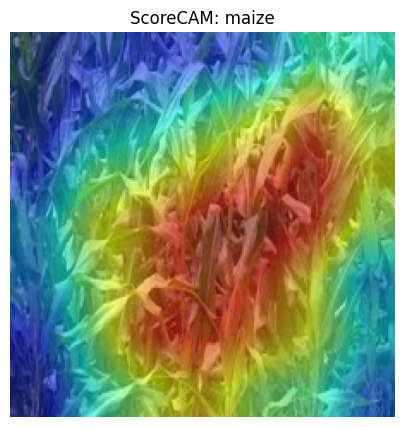

100%|██████████| 128/128 [07:22<00:00,  3.45s/it]


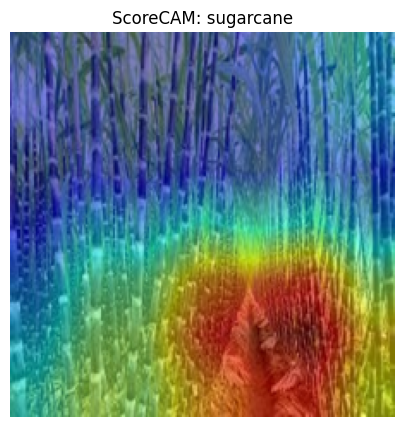

100%|██████████| 128/128 [06:46<00:00,  3.18s/it]


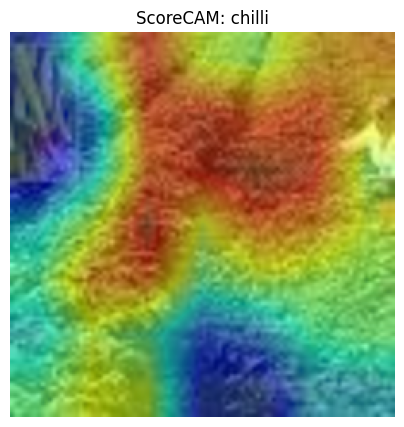

100%|██████████| 128/128 [07:01<00:00,  3.29s/it]


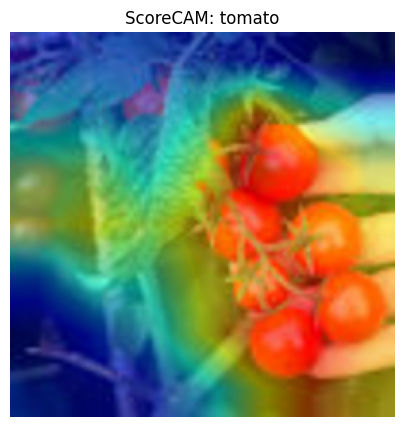

Execution time ScoreCAM: 2206.0125093460083 seconds


In [10]:
# try scoreCAM
start_time = time.time()
cam = ScoreCAM(model=model, target_layers=target_layers)

# replicate same thing for score CAM
for i,img_path in enumerate(sample_image_paths):
    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    input_tensor = transform(img).unsqueeze(0)

    # get prediction
    with torch.no_grad():
        output = model(input_tensor)
        class_idx = torch.argmax(output).item()

    # compute scoreCAM
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"ScoreCAM: {selected_classes[i]}")
    plt.axis("off")
    plt.show()
end_time = time.time()
print(f"Execution time ScoreCAM: {end_time - start_time} seconds")

## Part 5: Comparison and observation

For this exercise, I chose to visualize five images from a dataset of agricultural crops. I was interested in exploring what features excite or are most relevant for identifying different types of crops using a pre-trained ResNet-50 model and three different explainable deep learning methods: GradCAM, AblationCAM, and ScoreCAM.

After reviewing the results, I had the following reflections:

- Comparison of methods: The highlighted areas for each of the images (Cherry, Maize, Sugarcane, Chilli, and Tomato) were very similar, as each method emphasized roughly the same regions of the plants. However, the computation time differed as AblationCAM (45 mins) and ScoreCAM (37 mins) took noticeably longer to produce results compared to GradCAM (17 seconds).

- Focus areas: For most crops, the fruits were the primary regions highlighted, while fruits in the background or partially obscured were not used for identification. For example, in the tomato image, nearby tomatoes were identified, whereas those farther away were not.

- Leaves and stems: The leaves or stems were generally not emphasized in the visualizations, except for the sugarcane image, where the stem appeared to contribute to the model’s classification.